In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from collections import defaultdict
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
sns.set_style("darkgrid")
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
from collections import defaultdict


In [2]:
data = pd.read_csv("diabetes_prediction_dataset.csv")
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


**Check Of The Interdependence Between Featuers**

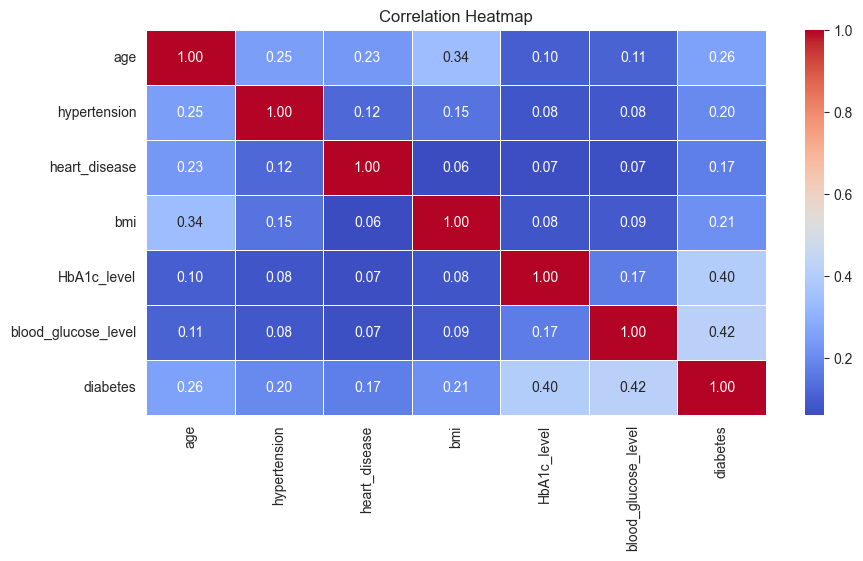

In [3]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


**Data Preprocessing**

In [4]:
print("Number of missing values:\n",data.isnull().sum())

Number of missing values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


**Features types**

In [5]:
categorical_features = [i for i in data.columns if data[i].dtype == 'O' and i != 'Diabetes']
numerical_features = [i for i in data.columns if data[i].dtype != 'O']
print(f"The categorical features are:\n{categorical_features}\n\n")
print(f"The numerical features are:\n{numerical_features}")

The categorical features are:
['gender', 'smoking_history']


The numerical features are:
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


In [6]:
def encode_categorical_columns(data):
    # Check if "gender" column exists before dropping
    if 'gender' in data.columns:
        data.drop('gender', axis=1, inplace=True)
    
    # Perform one-hot encoding for the "smoking_history" column
    data = pd.get_dummies(data, columns=['smoking_history'])
    
    return data

data = encode_categorical_columns(data)

In [7]:
def bin_numerical_columns(data, column, num_bins=5):
    # Perform binning using pd.cut
    data[f'{column}_bin'] = pd.cut(data[column], bins=num_bins, labels=False)
    return data

numerical_columns_to_bin = ['bmi', 'HbA1c_level', 'blood_glucose_level']

for column in numerical_columns_to_bin:
    data = bin_numerical_columns(data, column)

data.drop(numerical_columns_to_bin, axis=1, inplace=True)
data.drop('age', axis=1, inplace=True)


In [8]:
# The features and targets are separated
features = data.drop(['diabetes'], axis=1)
diabetes_target = data['diabetes']
print(features)

       hypertension  heart_disease  smoking_history_No Info  \
0                 0              1                    False   
1                 0              0                     True   
2                 0              0                    False   
3                 0              0                    False   
4                 1              1                    False   
...             ...            ...                      ...   
99995             0              0                     True   
99996             0              0                     True   
99997             0              0                    False   
99998             0              0                    False   
99999             0              0                    False   

       smoking_history_current  smoking_history_ever  smoking_history_former  \
0                        False                 False                   False   
1                        False                 False                   False   
2  

**Divide data into training and testing sets**

In [9]:
def divide_data(features, target, train_size):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=1-train_size, random_state=42)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test =divide_data(features, diabetes_target, 0.75)

**Calculate The Probability For Each Column**

In [10]:
def separate_by_class(X_train, y_train):
    separated = defaultdict(list)
    for i in range(len(X_train)):
        separated[y_train.iloc[i]].append(X_train.iloc[i])
    return separated

separated = separate_by_class(X_train, y_train)

In [11]:
def calculate_targetProp(y_train):
    targetProp = {}  # Prior probabilities of each class
    total_samples = len(y_train)
    for class_val in set(y_train):
        targetProp[class_val] = y_train.value_counts()[class_val] / total_samples
    return targetProp

targetProp = calculate_targetProp(y_train)
print(targetProp)

{0: 0.9153333333333333, 1: 0.08466666666666667}


In [12]:
def calculate_probabilities(separated):
    cond_prob = defaultdict(dict)  # Conditional probabilities of each feature given each class
    for class_val, instances in separated.items():
        class_data = pd.DataFrame(instances)
        for feature in class_data.columns:
            cond_prob[class_val][feature] = {}
            for value in set(class_data[feature]):
                cond_prob[class_val][feature][value] = (class_data[feature] == value).sum() / len(class_data)
    return cond_prob

cond_prob=calculate_probabilities(separated)
print(cond_prob)

defaultdict(<class 'dict'>, {0: {'hypertension': {0: 0.9400728332119447, 1: 0.059927166788055354}, 'heart_disease': {0: 0.9704151493080845, 1: 0.029584850691915514}, 'smoking_history_No Info': {False: 0.6247924253459578, True: 0.37520757465404225}, 'smoking_history_current': {False: 0.9098324836125273, True: 0.09016751638747268}, 'smoking_history_ever': {False: 0.9613983976693372, True: 0.03860160233066278}, 'smoking_history_former': {False: 0.9147997086671522, True: 0.08520029133284777}, 'smoking_history_never': {False: 0.6521922796795339, True: 0.34780772032046614}, 'smoking_history_not current': {False: 0.9369847050254916, True: 0.06301529497450838}, 'bmi_bin': {0: 0.4188201019664967, 1: 0.5643699927166788, 2: 0.01616897305171158, 3: 0.000582665695557174, 4: 5.826656955571741e-05}, 'HbA1c_level_bin': {0: 0.24952658412235978, 1: 0.24980335032774945, 2: 0.5006700655498908}, 'blood_glucose_level_bin': {0: 0.30801165331391117, 1: 0.6160524399126002, 2: 0.07593590677348871}}, 1: {'hypert

In [13]:
def fit(X_train, y_train):
    separated = separate_by_class(X_train, y_train)
    targetProp = calculate_targetProp(y_train)
    
    print("Prior probabilities:")
    for class_val, prob in targetProp.items():
        print(f"Class {class_val}: {prob}")
    
    cond_prob = calculate_probabilities(separated)
    
    print("\nConditional probabilities:")
    for class_val, features in cond_prob.items():
        print(f"\nClass {class_val}:")
        for feature, values in features.items():
            print(f"  Feature {feature}:")
            for value, prob in values.items():
                print(f"    Value {value}: {prob}")
    
    return targetProp, cond_prob

In [14]:
def predict(X_test, prior, cond_prob):
    predictions = []
    for index, instance in X_test.iterrows():
        posterior = {}
        for class_val, prior_prob in prior.items():
            likelihood = 1
            for feature, value in instance.items():
                likelihood *= cond_prob[class_val][feature].get(value, 0)
            posterior[class_val] = prior_prob * likelihood
        predictions.append(max(posterior, key=posterior.get))
    return predictions

targetProp, cond_prob = fit(X_train, y_train)

predictions = predict(X_test, targetProp, cond_prob)

Prior probabilities:
Class 0: 0.9153333333333333
Class 1: 0.08466666666666667

Conditional probabilities:

Class 0:
  Feature hypertension:
    Value 0: 0.9400728332119447
    Value 1: 0.059927166788055354
  Feature heart_disease:
    Value 0: 0.9704151493080845
    Value 1: 0.029584850691915514
  Feature smoking_history_No Info:
    Value False: 0.6247924253459578
    Value True: 0.37520757465404225
  Feature smoking_history_current:
    Value False: 0.9098324836125273
    Value True: 0.09016751638747268
  Feature smoking_history_ever:
    Value False: 0.9613983976693372
    Value True: 0.03860160233066278
  Feature smoking_history_former:
    Value False: 0.9147997086671522
    Value True: 0.08520029133284777
  Feature smoking_history_never:
    Value False: 0.6521922796795339
    Value True: 0.34780772032046614
  Feature smoking_history_not current:
    Value False: 0.9369847050254916
    Value True: 0.06301529497450838
  Feature bmi_bin:
    Value 0: 0.4188201019664967
    Value 1:

In [15]:
def predict_with_input(X_test, prior, cond_prob, y_test):
    predictions = []
    for person_id, (index, instance) in zip(X_test.index, X_test.iterrows()):
        posterior = {}
        for class_val, prior_prob in prior.items():
            likelihood = 1
            for feature, value in instance.items():
                likelihood *= cond_prob[class_val][feature].get(value, 0)
            posterior[class_val] = prior_prob * likelihood
        predicted_class = max(posterior, key=posterior.get)
        prediction_str = "Diabetes" if predicted_class == 1 else "No Diabetes"
        predictions.append(f"Person {person_id} {'has' if predicted_class == 1 else 'does not have'} diabetes")
    return predictions


predictions_with_input = predict_with_input(X_test, targetProp, cond_prob, y_test)

for prediction in predictions_with_input:
    print(prediction)



Person 75721 does not have diabetes
Person 80184 does not have diabetes
Person 19864 does not have diabetes
Person 76699 does not have diabetes
Person 92991 does not have diabetes
Person 76434 does not have diabetes
Person 84004 does not have diabetes
Person 80917 does not have diabetes
Person 60767 does not have diabetes
Person 50074 does not have diabetes
Person 27701 does not have diabetes
Person 42141 does not have diabetes
Person 45080 does not have diabetes
Person 16638 does not have diabetes
Person 20424 does not have diabetes
Person 88702 does not have diabetes
Person 149 does not have diabetes
Person 1761 does not have diabetes
Person 63120 does not have diabetes
Person 69161 does not have diabetes
Person 64883 does not have diabetes
Person 2495 does not have diabetes
Person 80296 does not have diabetes
Person 19447 does not have diabetes
Person 41331 does not have diabetes
Person 14888 does not have diabetes
Person 88636 does not have diabetes
Person 94892 does not have diabe

In [16]:
accuracy = accuracy_score(y_test, predictions)*100
print("Accuracy:", accuracy)


Accuracy: 96.452


**GUI**

In [17]:
def preprocess_and_train(file_path, train_size):
    data = pd.read_csv(file_path)
    numeric_data = data.select_dtypes(include=['number'])
    correlation_matrix = numeric_data.corr()
    categorical_features = [i for i in data.columns if data[i].dtype == 'O' and i != 'diabetes']
    numerical_columns_to_bin = ['bmi', 'HbA1c_level', 'blood_glucose_level']
    
    data = encode_categorical_columns(data)
    for column in numerical_columns_to_bin:
        data = bin_numerical_columns(data, column)
    data.drop(numerical_columns_to_bin, axis=1, inplace=True)
    data.drop('age', axis=1, inplace=True)
    
    features = data.drop(['diabetes'], axis=1)
    diabetes_target = data['diabetes']
    
    X_train, X_test, y_train, y_test = train_test_split(features, diabetes_target, test_size=1 - train_size, random_state=42)
    
    prior = calculate_targetProp(y_train)
    separated = separate_by_class(X_train, y_train)
    cond_prob = calculate_probabilities(separated)
    
    predictions = []
    for index, instance in X_test.iterrows():
        posterior = {}
        for class_val, prior_prob in prior.items():
            likelihood = 1
            for feature, value in instance.items():
                likelihood *= cond_prob[class_val][feature].get(value, 0)
            posterior[class_val] = prior_prob * likelihood
        predictions.append(max(posterior, key=posterior.get))
    
    accuracy = accuracy_score(y_test, predictions) * 100
    
    result_statements = []
    for person_id, true_label, prediction in zip(X_test.index, y_test, predictions):
        test_statement = f"Person {person_id} {'has' if true_label == 1 else 'does not have'} diabetes"
        pred_statement = f"Predicted: Person {person_id} {'has' if prediction == 1 else 'does not have'} diabetes"
        result_statements.append(test_statement)
        result_statements.append(pred_statement)
    
    return accuracy, result_statements

def browse_files():
    file_path = filedialog.askopenfilename()
    file_entry.delete(0, tk.END)
    file_entry.insert(0, file_path)

def process_data():
    file_path = file_entry.get()
    train_size = float(train_size_entry.get())
    
    accuracy, result_statements = preprocess_and_train(file_path, train_size)
    
    result_label.config(text=f"Accuracy: {accuracy:.2f} %")
    result_text.config(state=tk.NORMAL)
    result_text.delete(1.0, tk.END)
    for statement in result_statements:
        result_text.insert(tk.END, statement + '\n')
    result_text.config(state=tk.DISABLED)

window = tk.Tk()
window.title("Diabetes Prediction")

file_label = tk.Label(window, text="Select file:")
file_label.grid(row=0, column=0)
file_entry = tk.Entry(window, width=50)
file_entry.grid(row=0, column=1)
browse_button = tk.Button(window, text="Browse", command=browse_files)
browse_button.grid(row=0, column=2)

train_size_label = tk.Label(window, text="Training Data Size:")
train_size_label.grid(row=1, column=0)
train_size_entry = tk.Entry(window)
train_size_entry.grid(row=1, column=1)

process_button = tk.Button(window, text="Process Data", command=process_data)
process_button.grid(row=2, column=1)

result_label = tk.Label(window, text="")
result_label.grid(row=3, column=0, columnspan=3)

result_text = tk.Text(window, height=20, width=80)
result_text.grid(row=4, column=0, columnspan=3)
result_text.config(state=tk.DISABLED)

window.mainloop()
